In [2]:
%matplotlib inline
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models

from NetworkAPI import NetworkAPI

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data loaders

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.RandomCrop(28, padding=4),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', 
                                                  transform=data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=256, 
                                              shuffle=True, 
                                              num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## Network architecture template

```
class Network(nn.Module):
    def __init__(self):
        super(NetworkMaxMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
#             nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
#             nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
```

# Pooling tests

20 epochs

2 sekwencje: Conv, ReLU, Batch, Conv, ReLU, Batch, Pool

Wszystkie kombinacje Pooli:

* Max -- Max
* Max -- Avg
* Avg -- Max
* Avg -- Avg

In [ ]:
eps = 50

## Max -- Max

In [ ]:
class NetworkMaxMax(nn.Module):
    def __init__(self):
        super(NetworkMaxMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x64x64
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkMaxMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Max -- Avg

In [ ]:
class NetworkMaxAvg(nn.Module):
    def __init__(self):
        super(NetworkMaxAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkMaxAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Max -- No

In [ ]:
class NetworkMaxNo(nn.Module):
    def __init__(self):
        super(NetworkMaxNo, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkMaxNo().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxNo', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Max -- Conv

In [ ]:
class NetworkMaxConv(nn.Module):
    def __init__(self):
        super(NetworkMaxConv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkMaxConv().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxConv', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- Max

In [ ]:
class NetworkAvgMax(nn.Module):
    def __init__(self):
        super(NetworkAvgMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkAvgMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- Avg

In [ ]:
class NetworkAvgAvg(nn.Module):
    def __init__(self):
        super(NetworkAvgAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkAvgAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- No

In [ ]:
class NetworkAvgNo(nn.Module):
    def __init__(self):
        super(NetworkAvgNo, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkAvgNo().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgNo', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- Conv

In [ ]:
class NetworkAvgConv(nn.Module):
    def __init__(self):
        super(NetworkAvgConv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkAvgConv().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgConv', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## No -- Max

In [ ]:
class NetworkNoMax(nn.Module):
    def __init__(self):
        super(NetworkNoMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkNoMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## No -- Avg

In [ ]:
class NetworkNoAvg(nn.Module):
    def __init__(self):
        super(NetworkNoAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkNoAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## No -- No

In [ ]:
class NetworkNoNo(nn.Module):
    def __init__(self):
        super(NetworkNoNo, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkNoNo().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoNo', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## No -- Conv

In [4]:
class NetworkNoConv(nn.Module):
    def __init__(self):
        super(NetworkNoConv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkNoConv().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoConv', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 10
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  27.70s | Train loss:  2.11 | Train acc: 35.91|
| Epoch:   1 | Time:  12.62s | Val loss:    2.01 | Val acc:   46.01|
--------------------------------------------------------------------
| Epoch:   2 | Time:  26.67s | Train loss:  1.98 | Train acc: 48.08|
| Epoch:   2 | Time:  13.62s | Val loss:    1.94 | Val acc:   52.92|
--------------------------------------------------------------------


## Conv -- Max

In [ ]:
class NetworkConvMax(nn.Module):
    def __init__(self):
        super(NetworkConvMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkConvMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_ConvMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Conv -- Avg

In [ ]:
class NetworkConvAvg(nn.Module):
    def __init__(self):
        super(NetworkConvAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkConvAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_ConvAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Conv -- No

In [4]:
class NetworkConvNo(nn.Module):
    def __init__(self):
        super(NetworkConvNo, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 10
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  27.70s | Train loss:  2.11 | Train acc: 35.91|
| Epoch:   1 | Time:  12.62s | Val loss:    2.01 | Val acc:   46.01|
--------------------------------------------------------------------
| Epoch:   2 | Time:  26.67s | Train loss:  1.98 | Train acc: 48.08|
| Epoch:   2 | Time:  13.62s | Val loss:    1.94 | Val acc:   52.92|
--------------------------------------------------------------------
| Epoch:   3 | Time:  26.71s | Train loss:  1.93 | Train acc: 53.05|
| Epoch:   3 | Time:  14.09s | Val loss:    1.93 | Val acc:   52.69|
--------------------------------------------------------------------
| Epoch:   4 | Time:  26.75s | Train loss:  1.90 | Train acc: 56.73|
| Epoch:   4 | Time:  13.97s | Val loss:    1.91 | Val acc:   55.48|
--------------------------------------------------------------------
| Epoch:  

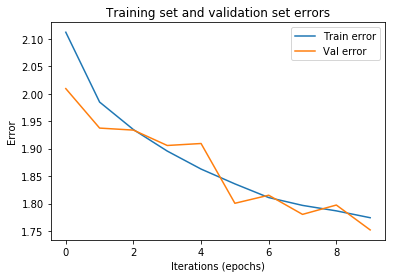

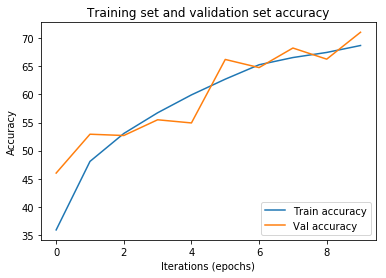

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 83.10% | 83.22%|
| Accuracy of: automobile | 80.98% | 80.84%|
| Accuracy of: bird       | 55.88% | 55.98%|
| Accuracy of: cat        | 52.96% | 53.32%|
| Accuracy of: deer       | 62.58% | 61.94%|
| Accuracy of: dog        | 55.42% | 55.32%|
| Accuracy of: frog       | 85.26% | 85.20%|
| Accuracy of: horse      | 76.04% | 76.12%|
| Accuracy of: ship       | 70.96% | 71.22%|
| Accuracy of: truck      | 87.46% | 87.28%|


In [5]:
np.random.seed = 0

model = NetworkConvNo().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_ConvNo', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Conv -- Conv

In [ ]:
class NetworkConvConv(nn.Module):
    def __init__(self):
        super(NetworkConvConv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkConvConv().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_ConvConv', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

# Batchnorm tests

## EverySequence

In [ ]:
class NetworkEverySequence(nn.Module):
    def __init__(self):
        super(NetworkEverySequence, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkEverySequence().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_batch_EverySequence', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## FirstSequence

In [ ]:
class NetworkFirstSequence(nn.Module):
    def __init__(self):
        super(NetworkFirstSequence, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 64x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkFirstSequence().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_batch_FirstSequence', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## EveryOfFirstSequence

In [ ]:
class NetworkEveryOfFirstSequence(nn.Module):
    def __init__(self):
        super(NetworkEveryOfFirstSequence, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkEveryOfFirstSequence().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_batch_EveryOfFirstSequence', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## SecondSequence


In [ ]:
class NetworkSecondSequence(nn.Module):
    def __init__(self):
        super(NetworkSecondSequence, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkSecondSequence().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_batch_SecondSequence', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

# Dropout tests

## NoDropout

In [ ]:
class NetworkNoDropout(nn.Module):
    def __init__(self):
        super(NetworkNoDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkNoDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_NoDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## FirstSequenceDropout

In [ ]:
class NetworkFirstSequenceDropout(nn.Module):
    def __init__(self):
        super(NetworkFirstSequenceDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.5) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkFirstSequenceDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_FirstSequenceDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## FirstSmallSequenceDropout

In [ ]:
class NetworkFirstSmallSequenceDropout(nn.Module):
    def __init__(self):
        super(NetworkFirstSmallSequenceDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkFirstSmallSequenceDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_FirstSmallSequenceDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## SwapedDropout

In [ ]:
class NetworkSwapedDropout(nn.Module):
    def __init__(self):
        super(NetworkSwapedDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.3) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.2) # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkSwapedDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_SwapedDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## FinalSequenceDropout

In [ ]:
class NetworkFinalSequenceDropout(nn.Module):
    def __init__(self):
        super(NetworkFinalSequenceDropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Dropout2d(0.3) # Output is 64x32x32
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*32*32, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*32*32)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
np.random.seed = 0

model = NetworkFinalSequenceDropout().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_dropout_FinalSequenceDropout', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)